<a href="https://colab.research.google.com/github/LisaRXN/bigdata_python/blob/main/Bigdata_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etape 1 : Importation des données

Imports et exploration des tables

---



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
import networkx as nx


pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Chargement des fichiers
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products = pd.read_csv('order_products.csv')

datasets = {
    "orders": orders,
    "products": products,
    "aisles": aisles,
    "departments": departments,
    "order_products": order_products
}

# Apperçu des fichiers
for name, data in datasets.items():
    print(f"\n{name.capitalize()} dataset:")
    display(data.head(4))


Orders dataset:


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0



Products dataset:


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1



Aisles dataset:


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods



Departments dataset:


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce



Order_products dataset:


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1


Vérification des données

---



In [7]:
# Vérification des valeurs nulles et des doublons
for name, data in datasets.items():
    print(f"\n{name.capitalize()} dataset:")

    # valeurs non définies
    nan_counts = data.isna().sum()
    print("Valeurs non définies par colonne :")
    print(nan_counts)

    # valeurs nulles
    null_counts = data.isnull().sum()
    print("Valeurs nulles par colonne :")
    print(null_counts[null_counts > 0])

    # doublons
    duplicate_count = data.duplicated().sum()
    print(f"Nombre de doublons : {duplicate_count}")
    print("-" * 40)


Orders dataset:
Valeurs non définies par colonne :
order_id                       0
user_id                        1
eval_set                       1
order_number                   1
order_dow                      1
order_hour_of_day              1
days_since_prior_order    167367
dtype: int64
Valeurs nulles par colonne :
user_id                        1
eval_set                       1
order_number                   1
order_dow                      1
order_hour_of_day              1
days_since_prior_order    167367
dtype: int64
Nombre de doublons : 0
----------------------------------------

Products dataset:
Valeurs non définies par colonne :
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
Valeurs nulles par colonne :
Series([], dtype: int64)
Nombre de doublons : 0
----------------------------------------

Aisles dataset:
Valeurs non définies par colonne :
aisle_id    0
aisle       0
dtype: int64
Valeurs nulles par colonne :
Series([], dtype:

Nettoyage des données inutiles

---



In [8]:
order_products = order_products.dropna()
orders = orders.dropna()


datasets["order_products"].dropna(subset=['reordered'], inplace=True)


# Etape 2 : Analyse des données

# Analyse n°1 - Optimisation de la gestion des stocks à travers l'analyse des ventes


**Problématique** :

Comment prévoir les produits qui seront populaires à l'avenir pour mieux gérer les stocks et éviter les ruptures et déchets ?

**Analyse**  :

*   Identifier les produits les plus commandés par secteur.

*   Analyser la fréquence des commandes pour anticiper les pics de demande.
*   Prévoir la demande future en utilisant des modèles simples.


**1. Total number of product purchases and reorders**

In [ ]:
# Calcul du nombre total d'achats
total_ordered = order_products['order_id'].count()
print("Total number of ordered products : ", total_ordered)

# Calcul du nombre total de réachats
total_reordered = order_products[order_products['reordered'] == 1].groupby('order_id')['product_id'].nunique().count()
print("Total number of reordered products : ", total_reordered)


Total number of ordered products :  32434489
Total number of reordered products :  2826361


**2. What are the most purchased products?**

In [ ]:
# Nombre total de fois qu'un produit a été acheté
product_counts = order_products.groupby('product_id').size().reset_index(name='order_count')

# Merge avec la table "products" pour obtenir les noms des produits
product_counts_merged = product_counts.merge(products, on='product_id')

# Trier par le nombre d'achats
top_products = product_counts_merged.sort_values(by='order_count', ascending=False).head(10)

# Calcul des pourcentages d'achat de chaque produit
order_pourcent = top_products['order_count'] * 100 / total_ordered
top_products['pourcent'] = order_pourcent.round(1)

display(top_products[['product_name', 'order_count', 'pourcent']])

,product_name,order_count,pourcent
24848,Banana,472565,13.8
13172,Bag of Organic Bananas,379450,11.1
21133,Organic Strawberries,264683,7.7
21899,Organic Baby Spinach,241921,7.1
47198,Organic Hass Avocado,213584,6.2
47755,Organic Avocado,176815,5.2
47615,Large Lemon,152657,4.5
16793,Strawberries,142951,4.2
26204,Limes,140627,4.1
27839,Organic Whole Milk,137905,4.0


**3. What are the most reordered products?**

In [ ]:
# Filtrer les produits réachetés (reordered = 1)
reordered_counts = order_products[order_products['reordered'] == 1].groupby('product_id').size().reset_index(name='reordered_count')

# Fusionner avec le dataset "products" pour obtenir les noms des produits
reordered_counts_merged = reordered_counts.merge(products, on='product_id')

# Trier par le nombre de réachats
top_reordered_products = reordered_counts_merged.sort_values(by='reordered_count', ascending=False).head(10)

# Calcul des pourcentages de réachat de chaque produit
reorder_pourcent = top_reordered_products['reordered_count'] * 100 / total_reordered
top_reordered_products['pourcent'] = reorder_pourcent.round(1)

display(top_reordered_products[['product_name', 'reordered_count', 'pourcent']])

,product_name,reordered_count,pourcent
22680,Banana,398609,14.1
11997,Bag of Organic Bananas,315913,11.2
19282,Organic Strawberries,205845,7.3
19973,Organic Baby Spinach,186884,6.6
43048,Organic Hass Avocado,170131,6.0
43552,Organic Avocado,134044,4.7
25420,Organic Whole Milk,114510,4.1
43429,Large Lemon,106255,3.8
25530,Organic Raspberries,105409,3.7
15321,Strawberries,99802,3.5


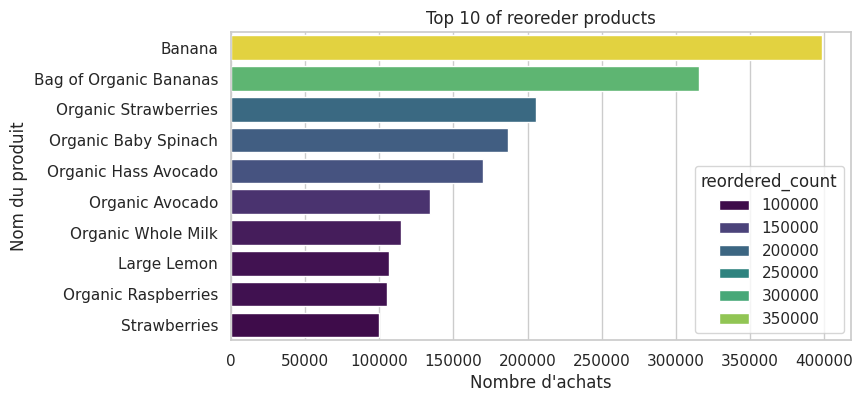

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x='reordered_count', y='product_name', data=top_reordered_products, palette='viridis', hue='reordered_count')
plt.title('Top 10 of reoreder products')
plt.xlabel('Nombre d\'achats')
plt.ylabel('Nom du produit')
plt.show()

**4. What ar the departments and aisles generating the most orders?**

In [ ]:
# Departments

# Lier les produits aux départements
product_departments = products.merge(departments, on='department_id')

# Calculer le nombre de produits vendus par département
department_orders = order_products.merge(product_departments, on='product_id').groupby('department').size().reset_index(name='order_count')

# Trier par nombre de ventes
top_departments = department_orders.sort_values(by='order_count', ascending=False).head(10)

# Calcul des pourcentages de vente de chaque département
department_pourcent = department_orders['order_count'] * 100 / total_ordered
top_departments['pourcent'] = department_pourcent.round(1)


# Aisles

# Lier les produits aux rayons
product_aisles = products.merge(aisles, on='aisle_id')

# Calculer le nombre de produits vendus par rayon
aisle_orders = order_products.merge(product_aisles, on='product_id').groupby('aisle').size().reset_index(name='order_count')

# Trier par nombre de ventes
top_aisles = aisle_orders.sort_values(by='order_count', ascending=False).head(10)

# Calcul des pourcentages de vente de chaque rayon
aisle_pourcent = aisle_orders['order_count'] * 100 / total_ordered
top_aisles['pourcent'] = aisle_pourcent.round(1)

# Affichage
display(top_departments[['department', 'order_count', 'pourcent']])
display(top_aisles[['aisle', 'order_count','pourcent']])

,department,order_count,pourcent
19,produce,9479291,29.2
7,dairy eggs,5414016,16.7
20,snacks,2887550,8.9
3,beverages,2690129,8.3
10,frozen,2236432,6.9
16,pantry,1875577,5.8
2,bakery,1176787,3.6
6,canned goods,1068058,3.3
8,deli,1051249,3.2
9,dry goods pasta,866627,2.7


,aisle,order_count,pourcent
50,fresh fruits,3642188,11.2
53,fresh vegetables,3418021,10.5
98,packaged vegetables fruits,1765313,5.4
133,yogurt,1452343,4.5
93,packaged cheese,979763,3.0
83,milk,891015,2.7
131,water seltzer sparkling water,841533,2.6
25,chips pretzels,722470,2.2
119,soy lactosefree,638253,2.0
11,bread,584834,1.8


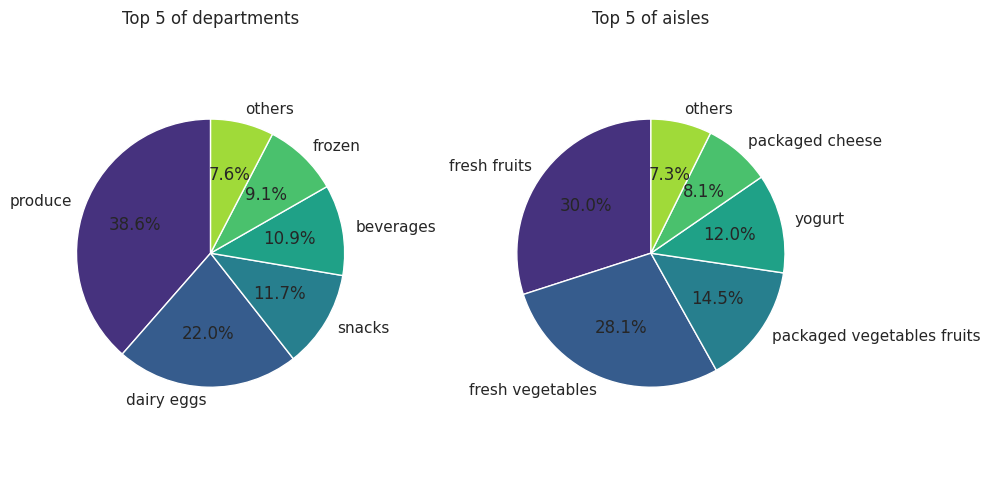

In [ ]:
# top 5 départements
top_departments = department_orders.sort_values(by='order_count', ascending=False).head(6)
top_departments.iloc[5, top_departments.columns.get_loc('department')] = 'others'

# top 5 allées
top_aisles = aisle_orders.sort_values(by='order_count', ascending=False).head(6)
top_aisles.iloc[5, top_aisles.columns.get_loc('aisle')] = 'others'

# figure avec deux graphiques
figure, axes = plt.subplots(1, 2, figsize=(10, 5))

# diagramme départements
axes[0].pie(top_departments['order_count'], labels=top_departments['department'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(top_departments)))
axes[0].set_title("Top 5 of departments")
axes[0].axis('equal')

# diagramme allées
axes[1].pie(top_aisles['order_count'], labels=top_aisles['aisle'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(top_aisles)))
axes[1].set_title("Top 5 of aisles")
axes[1].axis('equal')

# Affichage
plt.tight_layout()
plt.show()


**5. What are the days of the week and times of day generating the most orders?**


In [ ]:
# Nombre d'achats par jour de la semaine
daily_orders = orders.groupby('order_dow').size().reset_index(name='order_count')
days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
daily_orders['day_name'] = daily_orders['order_dow'].apply(lambda x: days[x])

print("Day with maximum orders:", daily_orders.sort_values(by='order_count', ascending=False).iloc[0]['day_name'])
print("Day with minimum orders:", daily_orders.sort_values(by='order_count', ascending=True).iloc[0]['day_name'])
print('\n')

# Nombre d'achats par heure de la journée
hourly_orders = orders.groupby('order_hour_of_day').size().reset_index(name='oder_count')

# Affichage
display(daily_orders)
print('\n')
display(hourly_orders)

Day with maximum orders: Lundi
Day with minimum orders: Vendredi




,order_dow,order_count,day_name
0,0,600905,Lundi
1,1,587478,Mardi
2,2,467260,Mercredi
3,3,436972,Jeudi
4,4,426339,Vendredi
5,5,453368,Samedi
6,6,448761,Dimanche


,order_hour_of_day,oder_count
0,0,22758
1,1,12398
2,2,7539
3,3,5474
4,4,5527
5,5,9569
6,6,30529
7,7,91868
8,8,178201
9,9,257812


Visualization of the days and hours generating most orders.



Day with maximum orders: Lun
Day with minimum orders: Ven
Hour of maximum orders:  13.0 





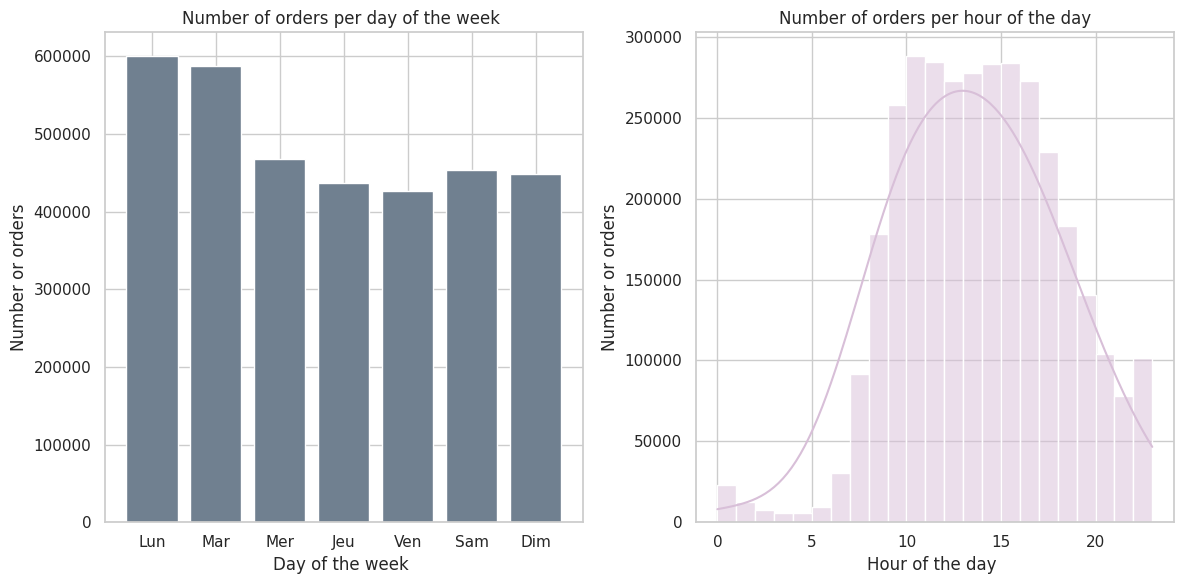

In [ ]:
# Affichage du nombre d'achats par jour de la semaine
daily_orders = orders.groupby('order_dow').size().reset_index(name='order_count')
days = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
daily_orders['day_name'] = daily_orders['order_dow'].apply(lambda x: days[x])

# Nombre d'achats par heure de la journée
hourly_orders = orders.groupby('order_hour_of_day').size().reset_index(name='order_count')

# Figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Premier histogramme pour les achats par jour de la semaine
axes[0].bar(daily_orders['day_name'], daily_orders['order_count'], color="slategray")
axes[0].set_title("Number of orders per day of the week ")
axes[0].set_xlabel("Day of the week ")
axes[0].set_ylabel("Number or orders")

# Deuxième histogramme pour les achats par heure de la journée
ax = sns.histplot(data=hourly_orders, x='order_hour_of_day', weights='order_count', binwidth=1, kde=True, color="thistle")
axes[1].set_title("Number of orders per hour of the day")
axes[1].set_xlabel("Hour of the day ")
axes[1].set_ylabel("Number or orders")

kde_line = ax.lines[0]
x_kde = kde_line.get_xdata()
y_kde = kde_line.get_ydata()
max_value = max(y_kde)
max_position = x_kde[np.argmax(y_kde)]

print('\n')
print("Day with maximum orders:", daily_orders.sort_values(by='order_count', ascending=False).iloc[0]['day_name'])
print("Day with minimum orders:", daily_orders.sort_values(by='order_count', ascending=True).iloc[0]['day_name'])
print( 'Hour of maximum orders: ', max_position.round(0), '\n')
print('\n')

plt.tight_layout()
plt.show()

**6. Correlation between the day of the week and the departments of the most ordered products?**

---

---






<ipython-input-23-4c229ee9e298>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_departments_grouped = orders_departments.groupby(['day_name', 'department']).size().reset_index(name='order_count')


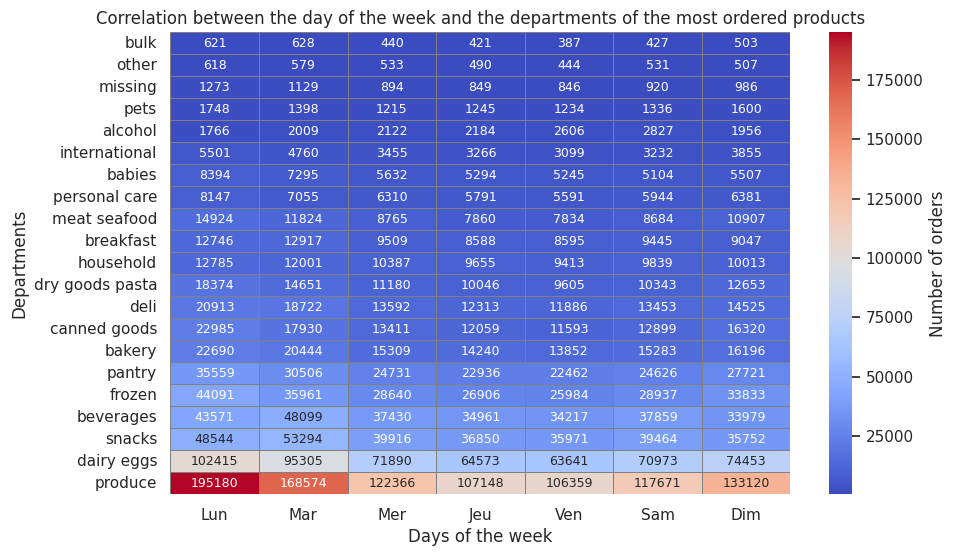

In [ ]:
# Échantillonner
orders_sample = orders.sample(frac=0.1, random_state=42)
order_products_sample = order_products.sample(frac=0.1, random_state=42)


orders_departments = (
    orders_sample
    .merge(order_products, on='order_id', how='left')
    .merge(products, on='product_id', how='left')
    .merge(departments, on='department_id', how='left')
)

days = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']

orders_departments['day_name'] = orders_departments['order_dow'].apply(lambda x: days[x])
orders_departments['day_name'] = pd.Categorical(orders_departments['day_name'], categories=days, ordered=True)


# # Regrouper les données par jour de la semaine et département
orders_departments_grouped = orders_departments.groupby(['day_name', 'department']).size().reset_index(name='order_count')

# Trier les départements en fonction des ventes totales, du plus grand au plus petit
department_sales = orders_departments_grouped.groupby('department')['order_count'].sum().reset_index().sort_values(by='order_count', ascending=True)

# # pivot pour les départements vs. jours de la semaine
department_pivot = orders_departments_grouped.pivot(index='department', columns='day_name', values='order_count')
department_pivot = department_pivot.loc[department_sales['department']]


# # Visualisation avec un heatmap
plt.figure(figsize=(10, 6))

sns.heatmap(
    department_pivot,
    cmap='coolwarm',
    annot=True,
    fmt='.0f',
    annot_kws={'size': 9},
    cbar_kws={'label': 'Number of orders'},
    linewidths=0.5,
    linecolor='gray')

plt.title("Correlation between the day of the week and the departments of the most ordered products")
plt.xlabel("Days of the week")
plt.ylabel("Departments")
plt.show()

**7. Correlation between hours of the day and departments of the most ordered products?**


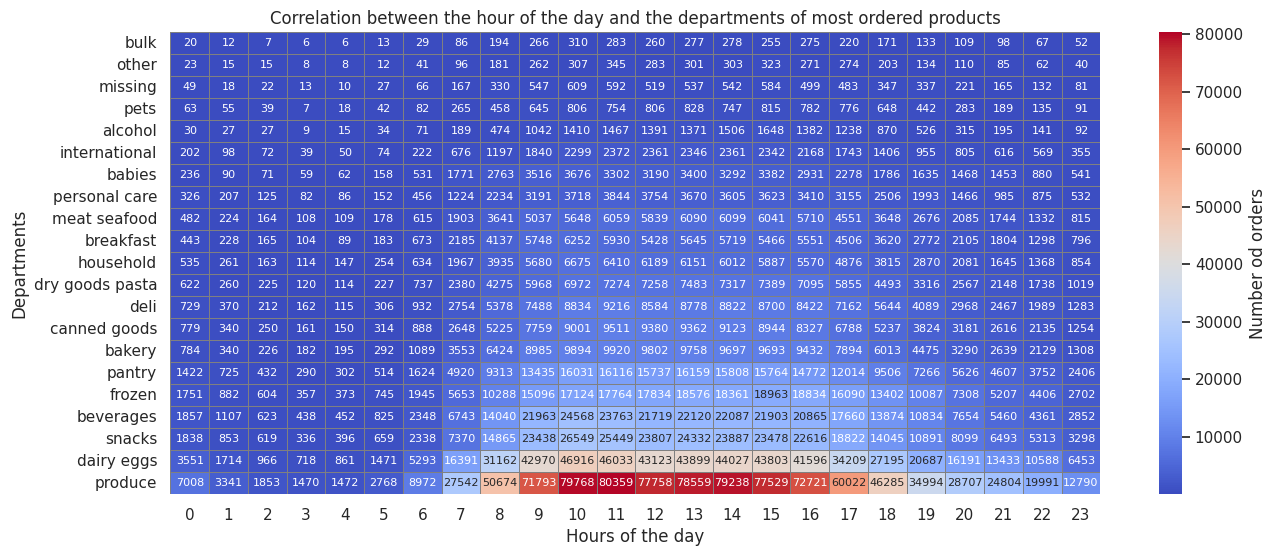

In [ ]:
# # Regrouper les données par heure et département
orders_departments_grouped = orders_departments.groupby(['order_hour_of_day', 'department']).size().reset_index(name='order_count')

# Trier les départements en fonction des ventes totales, du plus grand au plus petit
department_sales = orders_departments_grouped.groupby('department')['order_count'].sum().reset_index().sort_values(by='order_count', ascending=True)

# # pivot pour les départements (par 'department') vs. jours de la semaine
department_pivot = orders_departments_grouped.pivot(index='department', columns='order_hour_of_day', values='order_count')

department_pivot = department_pivot.loc[department_sales['department']]

# # Visualisation avec un heatmap
plt.figure(figsize=(15, 6))

sns.heatmap(
    department_pivot,
    cmap='coolwarm',
    annot=True,
    fmt='.0f',
    annot_kws={'size': 8},
    cbar_kws={'label': 'Number od orders'},
    linewidths=0.5,
    linecolor='gray')

plt.title("Correlation between the hour of the day and the departments of most ordered products")
plt.xlabel("Hours of the day")
plt.ylabel("Departments")
plt.show()

# Analyse n°2 - Optimisation de l'organisation du magasin à travers l'analyse des associations d'achat

In [3]:
# Échantillonner
orders = orders.sample(frac=0.2, random_state=42)
order_products = order_products.sample(frac=0.2, random_state=42)

**1. Analyze associations between products**

---

In [7]:
# Regrouper les produits par commande
orders_products= orders.merge(order_products, on='order_id', how='left').merge(products, on='product_id', how='left')

orders_products_group = orders_products.groupby('order_id')['product_name'].apply(list).reset_index()


# Chercher les association
product_pairing = []
for group in orders_products_group['product_name']:
    product_pairing.extend(combinations(group, 2))

# Compter les paires de produits
pair_counts = Counter(product_pairing)

# Afficher les paires les plus fréquentes
print("Paires de produits les plus fréquentes :")
for pair, count in pair_counts.most_common(5):
    print(f"{pair}: {count} fois")


,order_id,product_name
0,7,[Pineapple Chunks]
1,16,[Water]
2,17,[nan]
3,33,[Gourmet Mochi Ice Cream Vanilla Bonbons]
4,38,[nan]


Paires de produits les plus fréquentes :
('Bag of Organic Bananas', 'Organic Hass Avocado'): 275 fois
('Organic Strawberries', 'Bag of Organic Bananas'): 264 fois
('Organic Hass Avocado', 'Bag of Organic Bananas'): 261 fois
('Banana', 'Organic Avocado'): 244 fois
('Bag of Organic Bananas', 'Organic Strawberries'): 238 fois


**2. Analyze associations between departments**

---





In [30]:
orders_products = orders.merge(order_products, on='order_id', how='left').merge(products, on='product_id', how='left').merge(departments, on='department_id', how='left')

orders_products_group = orders_products.groupby('order_id')['department'].apply(list).reset_index()

# Chercher les associations entre départements
departments_pairing = []
for group in orders_products_group['department']:
    # Trier et créer des paires uniques (éviter doublons)
    departments_pairing.extend(combinations(sorted(set(group)), 2))

# Compter les combinaisons de départements
pair_counts = Counter(departments_pairing)

# Afficher les associations de départements les plus fréquentes
print("Associations de départements les plus fréquentes :")
for pair, count in pair_counts.most_common(10):
    print(f"{pair}: {count} fois")

Associations de départements les plus fréquentes :
('dairy eggs', 'produce'): 78871 fois
('produce', 'snacks'): 39559 fois
('beverages', 'produce'): 34494 fois
('frozen', 'produce'): 33450 fois
('dairy eggs', 'snacks'): 31108 fois
('pantry', 'produce'): 31040 fois
('beverages', 'dairy eggs'): 27686 fois
('dairy eggs', 'frozen'): 25749 fois
('dairy eggs', 'pantry'): 22486 fois
('bakery', 'produce'): 20543 fois


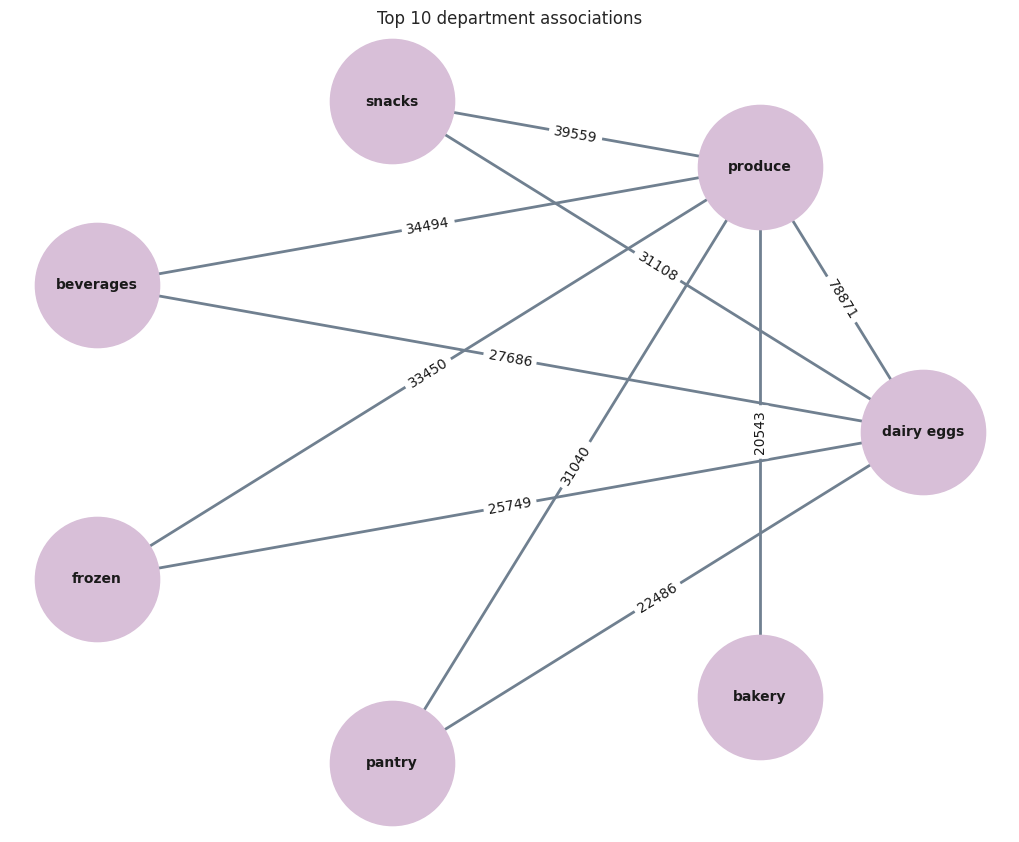

In [34]:
# Garder les 10 paires les plus fréquentes de pair_counts
top_10_pairs = dict(pair_counts.most_common(10))


# Créer le graphe
G = nx.Graph()

for pair, count in top_10_pairs.items():
    G.add_edge(pair[0], pair[1], weight=count)

plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=8000, node_color='thistle', font_size=10, font_weight='bold', edge_color='slategray', width=2)

# labels
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

plt.title('Top 10 department associations')
plt.show()

**3. Analyze associations between aisle**

---

In [36]:
orders_products = orders.merge(order_products, on='order_id', how='left').merge(products, on='product_id', how='left').merge(aisles, on='aisle_id', how='left')
orders_products_group = orders_products.groupby('order_id')['aisle'].apply(list).reset_index()

# Chercher les association
aisles_pairing = []
for group in orders_products_group['aisle']:
    # Trier et créer des paires uniques (éviter doublons)
    aisles_pairing.extend(combinations(sorted(set(group)), 2))

# Compter les paires de produits
pair_counts = Counter(aisles_pairing)

# Afficher les paires les plus fréquentes
print("Association d'allées les plus fréquentées :")
for pair, count in pair_counts.most_common(10):
    print(f"{pair}: {count} fois")

Association d'allées les plus fréquentées :
('fresh fruits', 'fresh vegetables'): 31225 fois
('fresh fruits', 'packaged vegetables fruits'): 19169 fois
('fresh vegetables', 'packaged vegetables fruits'): 18131 fois
('fresh fruits', 'yogurt'): 13826 fois
('fresh vegetables', 'yogurt'): 10625 fois
('fresh fruits', 'packaged cheese'): 9607 fois
('fresh vegetables', 'packaged cheese'): 8880 fois
('fresh fruits', 'milk'): 8620 fois
('packaged vegetables fruits', 'yogurt'): 7290 fois
('fresh vegetables', 'milk'): 6778 fois


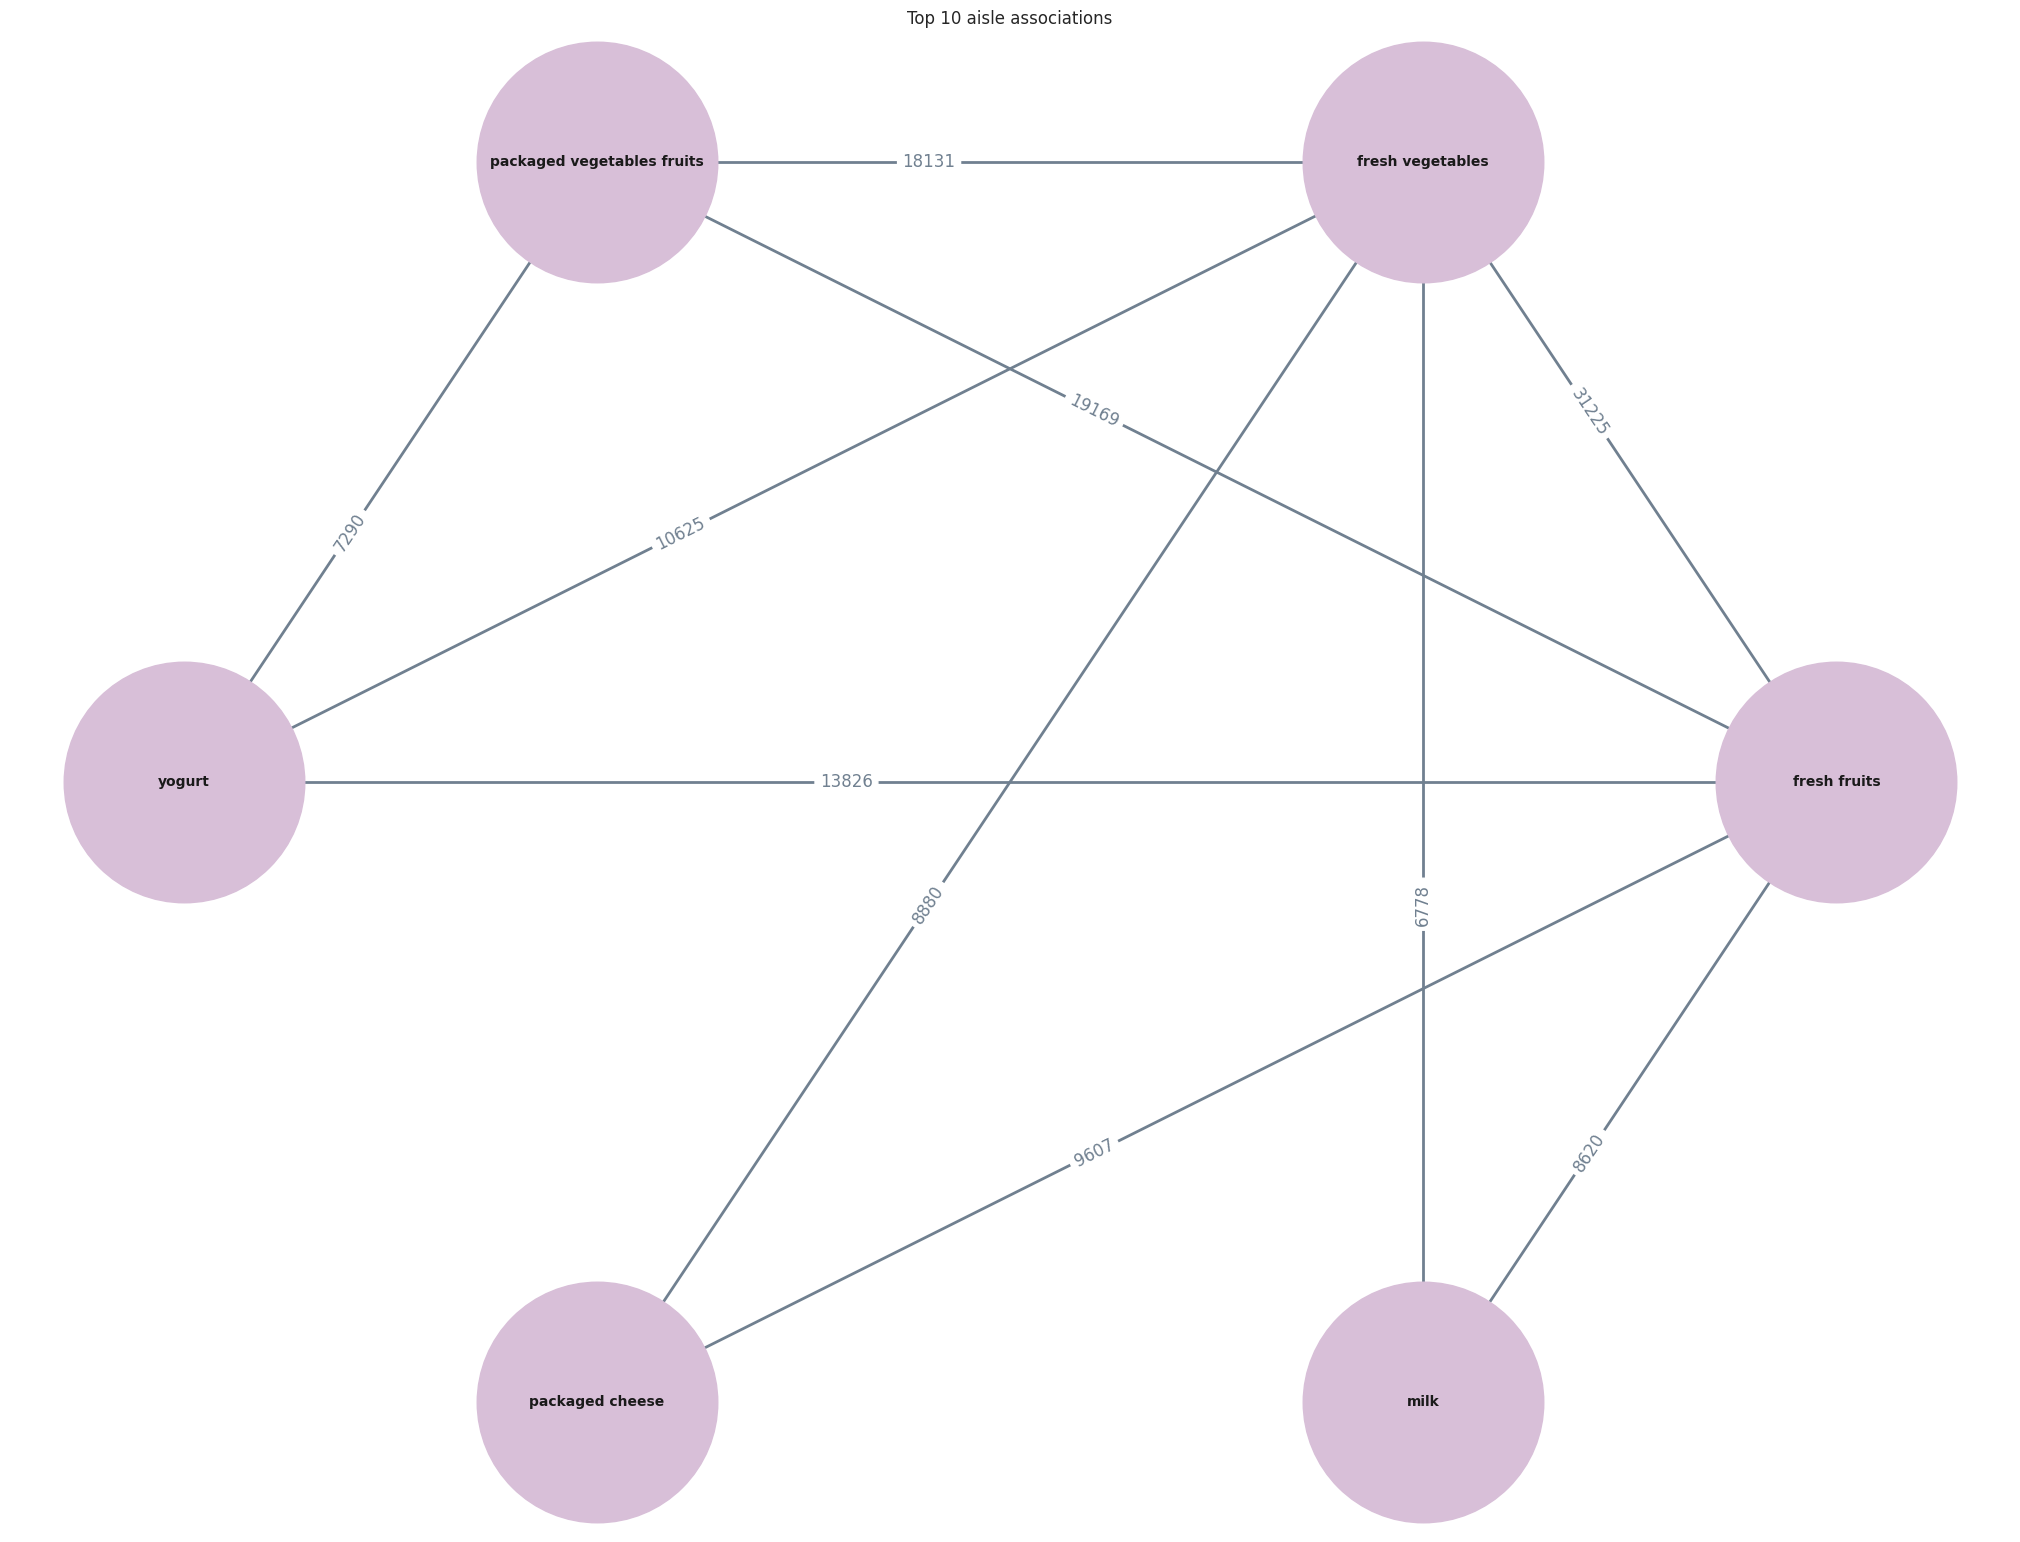

In [37]:
# Garder les 10 paires les plus fréquentes de pair_counts
top_10_pairs = dict(pair_counts.most_common(10))


# Créer le graphe
G = nx.Graph()

for pair, count in top_10_pairs.items():
    G.add_edge(pair[0], pair[1], weight=count)

plt.figure(figsize=(20, 15))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=30000, node_color='thistle', font_size=10, font_weight='bold', edge_color='slategray', width=2)

# labels
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12, font_color='slategray', label_pos=0.6)


plt.title('Top 10 aisle associations')
plt.show()